# Interact with Doctor in Training
## Role: Health Education England

## Before running through this notebook you should run through the following notebook - [Part 4.1](http://localhost:8891/notebooks/Part%204.1%20-%20Initialising%20the%20HEE%20Agent.ipynb).

## Or alternatively you can start at the beginning of the Doctors in Training flow [here](http://localhost:8889/notebooks/Part%201%20-%20Getting%20Started.ipynb).



## 1. Initialise a controller for Health Education England

In [18]:
%autoawait
import time
import asyncio
from termcolor import colored,cprint

from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8042
WEBHOOK_BASE = ""
ADMIN_URL = "http://hee-agent:8041"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)
    

IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic issue_credential, printing out the payload. The agent calls to this webhook every time it receives an issue-credential protocol message from a credential.

In [19]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

agent_controller.register_listeners([cred_listener,connection_listener], defaults=True)


## 3. Create a connection invitation to scan with the Mobile SSI Wallet

To make a connection with an identity holders wallet we must create a connection invitation and present the QR code to be scanned by the identity holders wallet. The identity holder scans this QR code and then can communicate with the agent through the exposed ngrok endpoint.

Once a connection is in an active state, the agent and the identity holders mobile wallet now have a secure pairwise relationship over which they can exchange verifiable credentials.

You must have a ssi wallet installed on your phone and connected to the Sovrin StagingNet for this to work.

### 3.1 Generate an invitation

In [20]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection message {'created_at': '2020-09-22 13:41:03.313296Z', 'connection_id': '4667d75b-540f-4618-a59b-3db7358fd023', 'routing_state': 'none', 'initiator': 'self', 'invitation_key': 'A8WnaUXB3V5TtJ1gmWQqyEpH1mXjuv3uxoXVJFWjrdEq', 'state': 'invitation', 'accept': 'auto', 'invitation_mode': 'once', 'updated_at': '2020-09-22 13:41:03.313296Z'} 4667d75b-540f-4618-a59b-3db7358fd023
Connection ID 4667d75b-540f-4618-a59b-3db7358fd023
Invitation
https://8c6f64f47aa4.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiNDMyNzk1ZjYtMmRhZi00ZjllLTljNWItN2E4MDVjZGM0NmJjIiwgInNlcnZpY2VFbmRwb2ludCI6ICJodHRwczovLzhjNmY2NGY0N2FhNC5uZ3Jvay5pbyIsICJyZWNpcGllbnRLZXlzIjogWyJBOFduYVVYQjNWNVR0SjFnbVdRcXlFcEgxbVhqdXYzdXhvWFZKRldqcmRFcSJdLCAibGFiZWwiOiAiSGVhbHRoIEVkdWNhdGlvbiBFbmdsYW5kIn0=


### 3.2 Display as QrCode to be Scanned by SSI Wallet

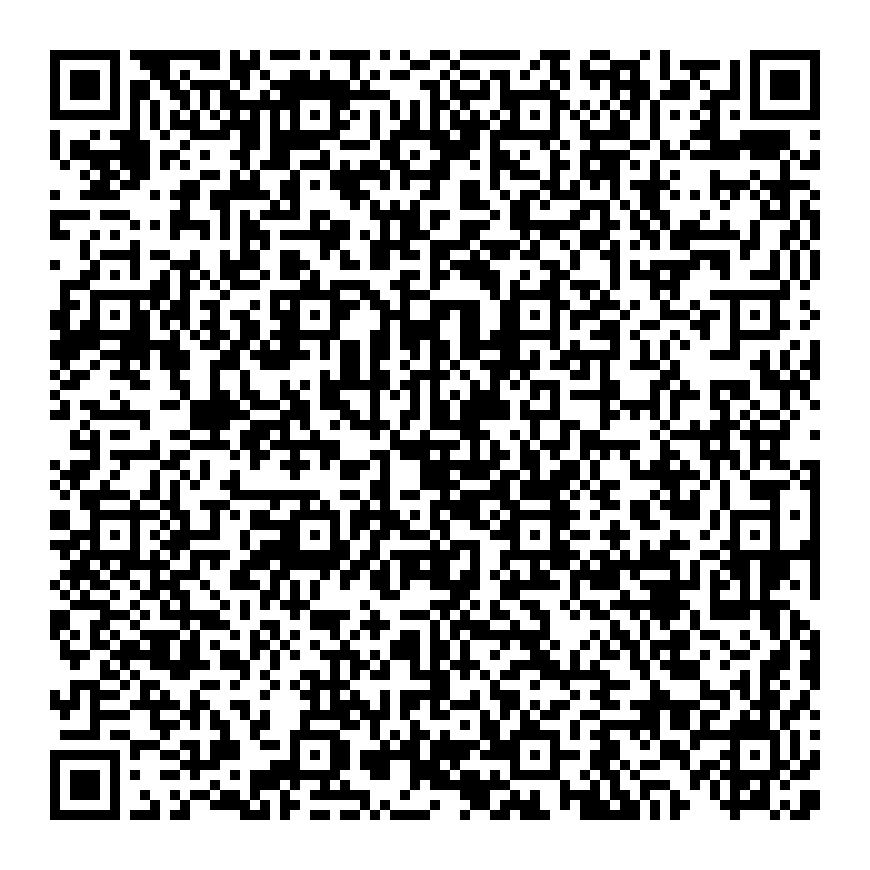

Connection message {'their_label': "Vineeth's Pixel 3", 'created_at': '2020-09-22 13:41:03.313296Z', 'their_did': 'U32dyhPNPoyLyEv7WYpJhw', 'connection_id': '4667d75b-540f-4618-a59b-3db7358fd023', 'routing_state': 'none', 'initiator': 'self', 'invitation_key': 'A8WnaUXB3V5TtJ1gmWQqyEpH1mXjuv3uxoXVJFWjrdEq', 'state': 'request', 'accept': 'auto', 'invitation_mode': 'once', 'updated_at': '2020-09-22 13:41:34.080922Z'} 4667d75b-540f-4618-a59b-3db7358fd023
Connection message {'their_label': "Vineeth's Pixel 3", 'created_at': '2020-09-22 13:41:03.313296Z', 'their_did': 'U32dyhPNPoyLyEv7WYpJhw', 'connection_id': '4667d75b-540f-4618-a59b-3db7358fd023', 'my_did': 'VQHujUb2K74UizvbYjfXyx', 'routing_state': 'none', 'initiator': 'self', 'invitation_key': 'A8WnaUXB3V5TtJ1gmWQqyEpH1mXjuv3uxoXVJFWjrdEq', 'state': 'response', 'accept': 'auto', 'invitation_mode': 'once', 'updated_at': '2020-09-22 13:41:34.275682Z'} 4667d75b-540f-4618-a59b-3db7358fd023


In [21]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)

qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('issuer_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./issuer_agent_invite_QRcode.png')

### 3.3 Check the connection is in the active state

In [22]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId 4667d75b-540f-4618-a59b-3db7358fd023 is response
ConnectionId 4667d75b-540f-4618-a59b-3db7358fd023 is not in active state yet
Trust ping send to ConnectionId {'thread_id': '36866c1d-d605-49fd-b96e-c2fc46dae284'} to activate connection
ConnectionId 4667d75b-540f-4618-a59b-3db7358fd023 is not in active state yet
Trust ping send to ConnectionId {'thread_id': '54fd0e9c-9f12-408c-9a25-f1d11b58eff4'} to activate connection
ConnectionId 4667d75b-540f-4618-a59b-3db7358fd023 is not in active state yet
Connection message {'their_label': "Vineeth's Pixel 3", 'created_at': '2020-09-22 13:41:03.313296Z', 'their_did': 'U32dyhPNPoyLyEv7WYpJhw', 'connection_id': '4667d75b-540f-4618-a59b-3db7358fd023', 'my_did': 'VQHujUb2K74UizvbYjfXyx', 'routing_state': 'none', 'initiator': 'self', 'invitation_key': 'A8WnaUXB3V5TtJ1gmWQqyEpH1mXjuv3uxoXVJFWjrdEq', 'state': 'active', 'accept': 'auto', 'invitation_mode': 'once', 'updated_at': '2020-09-22 13:41:42.881891Z'} 4667d75b-540f-461

## 4. Request Passport Details Presentation

## 4a. Generate proof request

In [23]:
print("Request proof of Passport information")

#Set some variables

REVOCATION = False
SELF_ATTESTED = False
EXCHANGE_TRACING = False

req_attrs = [
    {"name": "PSS Given Names", "restrictions": []},
    {"name": "PSS Surname", "restrictions": []},
]

if REVOCATION:
    req_attrs.append(
        {
            "name": "skill",
            "restrictions": [{"schema_id": schema_id}],
            "non_revoked": {"to": int(time.time() - 1)},
        },
    )

if SELF_ATTESTED:
    # test self-attested claims
    req_attrs.append({"name": "country"},)

#Set predicates for Zero Knowledge Proofs
req_preds = []

indy_proof_request = {
    "name": "Proof of Passport Credential",
    "version": "1.0",
    "requested_attributes": {
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
    },
    "requested_predicates": {
        f"0_{req_pred['name']}_GE_uuid":
        req_pred for req_pred in req_preds
    },
}

if REVOCATION:
    indy_proof_request["non_revoked"] = {"to": int(time.time())}

#proof_request = indy_proof_request
exchange_tracing_id = EXCHANGE_TRACING
proof_request_web_request = {
    "connection_id": connection_id,
    "proof_request": indy_proof_request,
    "trace": EXCHANGE_TRACING,
}

Request proof of Passport information


### 4b. Send the proof request to Doctor

Doctor is identified through the connection_id

In [24]:
response = await agent_controller.proofs.send_request(proof_request_web_request)
print(response)
presentation_exchange_id = response['presentation_exchange_id']
print("\n")
print(presentation_exchange_id)

{'created_at': '2020-09-22 13:41:51.930252Z', 'presentation_request_dict': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/present-proof/1.0/request-presentation', '@id': 'b14d8947-cdbf-40b6-8406-5df996419437', 'request_presentations~attach': [{'@id': 'libindy-request-presentation-0', 'mime-type': 'application/json', 'data': {'base64': 'eyJuYW1lIjogIlByb29mIG9mIFBhc3Nwb3J0IENyZWRlbnRpYWwiLCAidmVyc2lvbiI6ICIxLjAiLCAicmVxdWVzdGVkX2F0dHJpYnV0ZXMiOiB7IjBfUFNTIEdpdmVuIE5hbWVzX3V1aWQiOiB7Im5hbWUiOiAiUFNTIEdpdmVuIE5hbWVzIiwgInJlc3RyaWN0aW9ucyI6IFtdfSwgIjBfUFNTIFN1cm5hbWVfdXVpZCI6IHsibmFtZSI6ICJQU1MgU3VybmFtZSIsICJyZXN0cmljdGlvbnMiOiBbXX19LCAicmVxdWVzdGVkX3ByZWRpY2F0ZXMiOiB7fSwgIm5vbmNlIjogIjExNzg1Njk0ODk1NTExNjgwNzg0MzAyMDUifQ=='}}]}, 'auto_present': False, 'role': 'verifier', 'connection_id': '4667d75b-540f-4618-a59b-3db7358fd023', 'thread_id': 'b14d8947-cdbf-40b6-8406-5df996419437', 'initiator': 'self', 'state': 'request_sent', 'presentation_exchange_id': '0418e2c3-2d2a-4b09-95ee-b99c3e52bc7

## 4c. Verify proof presentation and populate credential template

This is checking the signatures on the credentials presented against the credential schema and definition id stored and resolvable on the ledger. It is a bit of a big complicated object, so we show the common pattern for breaking it down, checking it's verified and accessing the data that has been presented.

In [26]:
verify = await agent_controller.proofs.verify_presentation(presentation_exchange_id)

# print proof request verification status
print('Proof request state verified?: {} '.format(verify['state'] == 'verified'))


Proof request state verified?: True 


In [27]:
# access the revealed attributes and populate credential
credential_attributes = []
for (name, val) in verify['presentation']['requested_proof']['revealed_attrs'].items():
    ## This is the actual data that you want. It's a little hidden
    print('Atribute name: {} Value: {}'.format(name[6:-5],val['raw']))
    credential_attributes.append({"name":name[6:-5], "value": val['raw']})
    
# set credential attribute field names to match credential
credential_attributes[0]['name'] = "RTW Given Names"
credential_attributes[1]['name'] = "RTW Surname"

Atribute name: Given Names Value: Micheal
Atribute name: Surname Value: Jones


In [28]:
print(credential_attributes)

[{'name': 'RTW Given Names', 'value': 'Micheal'}, {'name': 'RTW Surname', 'value': 'Jones'}]


## 5 Issue Right to Work Credential

### 5.1 Retrieve stored `cred_def_id` and `schema_id`s

In [29]:
# load all globally stored variables
%store -r training_program_schema_id
%store -r training_program_cred_def_id
%store -r right_to_work_schema_id
%store -r right_to_work_cred_def_id
%store -r training_placement_schema_id
%store -r training_placement_cred_def_id

### 5.1 Fetch the credential definition for the schema


In [63]:
# response = await agent_controller.wallet.get_public_did()
# print(response)
# hee_public_did = response["result"]["did"]
# definitions = await agent_controller.definitions.search_created(issuer_did=hee_public_did, schema_id=right_to_work_schema_id)

# right_to_work_cred_def_id = None
# cred_def_ids = definitions['credential_definition_ids']
# if len(cred_def_ids) == 0:
#     print("You have not written a credential definition to the ledger for this public DID")
# else:
#     right_to_work_cred_def_id = cred_def_ids[0]
#     print(right_to_work_cred_def_id)
    


### 5.2 Populate the Mandatory Training Credential Attributes

In [30]:
residency = input("Please enter residency status:")
visa = input("Please enter the VISA type :")
visa_exp = input("Please enter VISA Expiry date : ")

credential_attributes.append({"name":"RTW Residency Status", "value": residency})
credential_attributes.append({"name":"RTW Visa Type", "value": visa})
credential_attributes.append({"name":"RTW Visa Expiry Date", "value": visa_exp})
print(credential_attributes)


Please enter residency status:123
Please enter the VISA type :123123
Please enter VISA Expiry date : 213132
[{'name': 'RTW Given Names', 'value': 'Micheal'}, {'name': 'RTW Surname', 'value': 'Jones'}, {'name': 'RTW Residency Status', 'value': '123'}, {'name': 'RTW Visa Type', 'value': '123123'}, {'name': 'RTW Visa Expiry Date', 'value': '213132'}]


### 5.3 Issue the Mandatory Training Credential 

In [31]:
record = await agent_controller.issuer.send_credential(connection_id, right_to_work_schema_id, right_to_work_cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")

Credential exchange 6423afbc-0ef5-414d-9aa1-5d2b90f65e24, role: issuer, state: offer_sent
Handle Credentials
Credential exchange 6423afbc-0ef5-414d-9aa1-5d2b90f65e24, role: issuer, state: offer_sent
Offering: [{'name': 'RTW Given Names', 'value': 'Micheal'}, {'name': 'RTW Surname', 'value': 'Jones'}, {'name': 'RTW Residency Status', 'value': '123'}, {'name': 'RTW Visa Type', 'value': '123123'}, {'name': 'RTW Visa Expiry Date', 'value': '213132'}]
Handle Credentials
Credential exchange 6423afbc-0ef5-414d-9aa1-5d2b90f65e24, role: issuer, state: request_received
Offering: [{'name': 'RTW Given Names', 'value': 'Micheal'}, {'name': 'RTW Surname', 'value': 'Jones'}, {'name': 'RTW Residency Status', 'value': '123'}, {'name': 'RTW Visa Type', 'value': '123123'}, {'name': 'RTW Visa Expiry Date', 'value': '213132'}]
Handle Credentials
Credential exchange 6423afbc-0ef5-414d-9aa1-5d2b90f65e24, role: issuer, state: credential_issued
Offering: [{'name': 'RTW Given Names', 'value': 'Micheal'}, {'name

## 6 Issue a Training Program Credential

### 6.1 Fetch the associated credential definition id written to the Ledger in Part 4.1

This will fail if a credential definition has not been written to the ledger by the HEE agent's public DID.

In [66]:
# response = await agent_controller.wallet.get_public_did()
# print(response)
# hee_public_did = response["result"]["did"]
# training_program_schema_id = "2yWoMSfeTtYBFpUJFcnpqL:2:Training Programme:0.0.1"
# definitions = await agent_controller.definitions.search_created(issuer_did=hee_public_did, schema_id=training_program_schema_id)

# training_program_cred_def_id = None
# cred_def_ids = definitions['credential_definition_ids']
# if len(cred_def_ids) == 0:
#     print("You have not written a credential definition to the ledger for this public DID")
# else:
#     training_program_cred_def_id = cred_def_ids[0]
#     print(training_program_cred_def_id)
    


### 6.2 Populate the Training Program attributes to Issue to Doctor

This would typically be done through a face to face identity check.

The notebook will ask you to input all the relevant fields.

In [32]:
lead_employee = input("Please enter the doctors lead employee: ")
clinical_supervisor=input("Please enter the doctors clinical supervisor: ")
academic_supervisor=input("Please enter the doctors academic supervisor: ")
program_name = input("Please enter the name of the training program: ")
program_year=input("Please enter the current year of the program: ")
start_date=input("Please enter the programs start date: ")
scheduled_end = input("Please enter the scheduled end date: ")
extended_end=input("Please enter the extended_end_date: ")

credential_attributes = [
    {"name": "TPR Lead Employer", "value": lead_employee},
    {"name": "TPR Clinical Supervisor", "value": clinical_supervisor},
    {"name": "TPR Academic Supervisor", "value": academic_supervisor},
    {"name": "TPR Training Programme Name", "value": program_name},
    {"name": "TPR Programme Current Year", "value": program_year},
    {"name": "TPR Start Date", "value": start_date},
    {"name": "TPR Scheduled End Date", "value": scheduled_end},
    {"name": "TPR Extended End Date", "value": extended_end},

]




print(credential_attributes)

Please enter the doctors lead employee: John
Please enter the doctors clinical supervisor: adam
Please enter the doctors academic supervisor: henry
Please enter the name of the training program: adfsa
Please enter the current year of the program: 123213
Please enter the programs start date: 126361
Please enter the scheduled end date: 12
Please enter the extended_end_date: 23
[{'name': 'TPR Lead Employer', 'value': 'John'}, {'name': 'TPR Clinical Supervisor', 'value': 'adam'}, {'name': 'TPR Academic Supervisor', 'value': 'henry'}, {'name': 'TPR Training Programme Name', 'value': 'adfsa'}, {'name': 'TPR Programme Current Year', 'value': '123213'}, {'name': 'TPR Start Date', 'value': '126361'}, {'name': 'TPR Scheduled End Date', 'value': '12'}, {'name': 'TPR Extended End Date', 'value': '23'}]


## 6.3 Issue Training Program Credential

This sends a credential to the doctor's mobile wallet you just connected with.

In [33]:
record = await agent_controller.issuer.send_credential(connection_id, training_program_schema_id, training_program_cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


Credential exchange a4543886-e20d-452c-af62-d13305e8a97c, role: issuer, state: offer_sent
Handle Credentials
Credential exchange a4543886-e20d-452c-af62-d13305e8a97c, role: issuer, state: offer_sent
Offering: [{'name': 'TPR Lead Employer', 'value': 'John'}, {'name': 'TPR Clinical Supervisor', 'value': 'adam'}, {'name': 'TPR Academic Supervisor', 'value': 'henry'}, {'name': 'TPR Training Programme Name', 'value': 'adfsa'}, {'name': 'TPR Programme Current Year', 'value': '123213'}, {'name': 'TPR Start Date', 'value': '126361'}, {'name': 'TPR Scheduled End Date', 'value': '12'}, {'name': 'TPR Extended End Date', 'value': '23'}]
Handle Credentials
Credential exchange a4543886-e20d-452c-af62-d13305e8a97c, role: issuer, state: request_received
Offering: [{'name': 'TPR Lead Employer', 'value': 'John'}, {'name': 'TPR Clinical Supervisor', 'value': 'adam'}, {'name': 'TPR Academic Supervisor', 'value': 'henry'}, {'name': 'TPR Training Programme Name', 'value': 'adfsa'}, {'name': 'TPR Programme C

## 7. Issue Training Placement Credential

### 7.1 Fetch the relevant credential definition

In [69]:

# response = await agent_controller.wallet.get_public_did()
# hee_public_did = response["result"]["did"]
# training_placement_schema_id = "2yWoMSfeTtYBFpUJFcnpqL:2:Training Programme Placement:0.0.1"
# definitions = await agent_controller.definitions.search_created(issuer_did=hee_public_did, schema_id=training_placement_schema_id)

# training_placement_cred_def_id = None
# cred_def_ids = definitions['credential_definition_ids']
# if len(cred_def_ids) == 0:
#     print("You have not written a credential definition to the ledger for this public DID")
# else:
#     training_placement_cred_def_id = cred_def_ids[0]
#     print(training_placement_cred_def_id)
    

### 7.2 Populate the Training Placement Credential Attributes

In [34]:
placement_name = input("Please enter the name of the placement: ")
employer=input("Please enter the placement employer: ")
location=input("Please enter the location of the placement: ")
start_date = input("Please enter the placement start date: ")
sched_end_date =input("Please enter the scheduled end of the placement: ")
extended_end_date=input("Please enter the extended end date: ")
actual_end = input("Please enter the actual end date: ")
position_id =input("Please enter the placements position id: ")

credential_attributes = [
     {"name":"TPP Placement Name", "value": placement_name},
     {"name":"TPP Placement Employer", "value": employer},
     {"name":"TPP Placement Location", "value": location},
     {"name":"TPP Placement StartDate", "value": start_date},
     {"name":"TPP Placement Sched End Date", "value": sched_end_date},
     {"name":"TPP Placement Ext. End Date", "value": extended_end_date},
     {"name":"TPP Placement Act End Date", "value": actual_end},
     {"name":"TPP PositionId", "value": position_id}
]
print(credential_attributes)

Please enter the name of the placement: hfs
Please enter the placement employer: sdfsa
Please enter the location of the placement: fsad
Please enter the placement start date: dsa
Please enter the scheduled end of the placement: asdf
Please enter the extended end date: adsf
Please enter the actual end date: dfa
Please enter the placements position id: sdf
[{'name': 'TPP Placement Name', 'value': 'hfs'}, {'name': 'TPP Placement Employer', 'value': 'sdfsa'}, {'name': 'TPP Placement Location', 'value': 'fsad'}, {'name': 'TPP Placement StartDate', 'value': 'dsa'}, {'name': 'TPP Placement Sched End Date', 'value': 'asdf'}, {'name': 'TPP Placement Ext. End Date', 'value': 'adsf'}, {'name': 'TPP Placement Act End Date', 'value': 'dfa'}, {'name': 'TPP PositionId', 'value': 'sdf'}]


### 7.3 Issue the Training Placement Credential

In [35]:
record = await agent_controller.issuer.send_credential(connection_id, training_placement_schema_id, training_placement_cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")

Credential exchange 4e33920a-4b7b-44ed-b42e-65dec154a1b4, role: issuer, state: offer_sent
Handle Credentials
Credential exchange 4e33920a-4b7b-44ed-b42e-65dec154a1b4, role: issuer, state: offer_sent
Offering: [{'name': 'TPP Placement Name', 'value': 'hfs'}, {'name': 'TPP Placement Employer', 'value': 'sdfsa'}, {'name': 'TPP Placement Location', 'value': 'fsad'}, {'name': 'TPP Placement StartDate', 'value': 'dsa'}, {'name': 'TPP Placement Sched End Date', 'value': 'asdf'}, {'name': 'TPP Placement Ext. End Date', 'value': 'adsf'}, {'name': 'TPP Placement Act End Date', 'value': 'dfa'}, {'name': 'TPP PositionId', 'value': 'sdf'}]
Handle Credentials
Credential exchange 4e33920a-4b7b-44ed-b42e-65dec154a1b4, role: issuer, state: request_received
Offering: [{'name': 'TPP Placement Name', 'value': 'hfs'}, {'name': 'TPP Placement Employer', 'value': 'sdfsa'}, {'name': 'TPP Placement Location', 'value': 'fsad'}, {'name': 'TPP Placement StartDate', 'value': 'dsa'}, {'name': 'TPP Placement Sched E

## 8. End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [36]:
response = await agent_controller.terminate()
print(response)

None


# You can now proceed to interact with the [Lead Employer](http://127.0.0.1:8892)

Find the notebook access token by running `docker logs  interopen-hack_lead-employer-notebook_1`
